In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits
from data_process import weight_nan_mean, load_calculation_data, calculate_jackknife_variance
from sklearn.neighbors import KDTree

In [2]:
Nside_jack = 4
r_p, dat = load_calculation_data('../calculation_data/result_r=3_100_15_quasar_lss_CMB_lcut_n_2048_tree.npy', return_rp=True)
dat_r = load_calculation_data('../calculation_data/result_r=3_100_15_random_quasar_lss_CMB_lcut_n_2048_tree.npy')

In [3]:
value_r = dat_r[0]
weight_r = dat_r[1]

quasar_cata = np.load('../catalogue/quasar_lss.npy')
c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_q = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

quasar_SDSS = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
tree = KDTree(np.c_[quasar_SDSS['RA'], quasar_SDSS['DEC']], metric='euclidean')
que = tree.query(np.c_[quasar_cata['ra'], quasar_cata['dec']])
valid = que[0].flatten() < 5/3600
index = que[1].flatten()

M_I = quasar_SDSS['M_I'][index]
M_I[~valid] = np.nan
mid = np.percentile(M_I[valid], 50)
left_index = M_I.flatten() <= mid
right_index = M_I.flatten() >= mid
print('finish loading quasar catalogue')

random_sample = np.load('../catalogue/random_quasar_lss.npy')
c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)
assert (random_sample['w']==1).all()
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)


print('finish loading random sample')

finish loading quasar catalogue
finish loading random sample


In [5]:
bins = np.linspace(1, 2, 30)
result = np.digitize(quasar_cata['z'], bins)
kind = np.zeros(len(quasar_cata), int)
middles = []
high = []
low = []
for i in range(1, 30):
    index = np.where(result == i)[0]
    M = M_I[index]
    middle = np.percentile(M[~np.isnan(M)], 50)
#   print(middle)
    high.append(index[M <= middle])
    low.append(index[M >= middle])

index_h = np.concatenate(high)
index_l = np.concatenate(low)

In [6]:
index = index_l
suffix = 'low_L'

value = dat[0,index]
weight = dat[1,index]
pix = pix_q[index]

In [7]:
savefig = False

## quasar sample

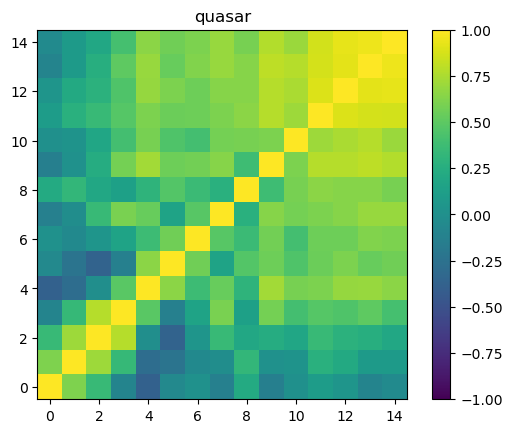

In [10]:
#sampler_sub = jackknife_sampler(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True)
#plt.imshow(sampler_sub.cov_mat, origin='lower', vmin=-1, vmax=1)
sampler_q = calculate_jackknife_variance(value, weight, pix, norm_cov=True)
plt.imshow(sampler_q['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('quasar')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_qr')
plt.show()

## random sample

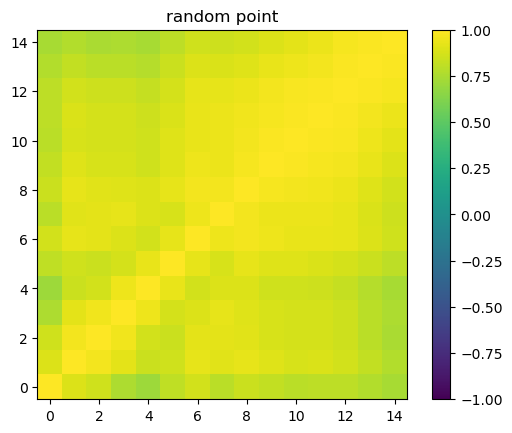

In [9]:
#sampler_r = jackknife_sampler(value_r, weight_r, pix_r, norm_cov=True, Npro=60)
sampler_r = calculate_jackknife_variance(value_r, weight_r, pix_r, norm_cov=True)

plt.imshow(sampler_r['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('random point')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_r')
plt.show()

## quasar - random

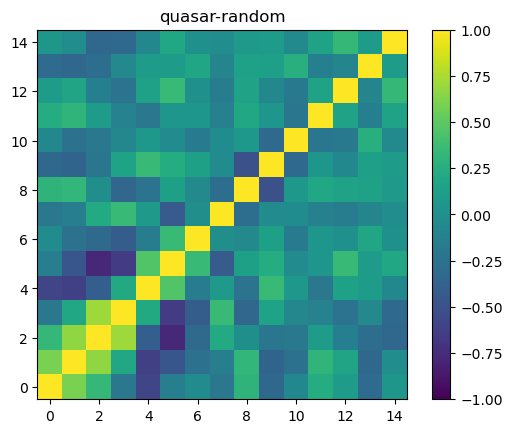

In [11]:
#sampler_sub = jackknife_sampler(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True)
sampler_sub  = calculate_jackknife_variance(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True)
plt.imshow(sampler_sub['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('quasar-random')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_qr')
plt.show()

## signal

In [12]:
np.savetxt(f'quasar_lss_sigma_{suffix}', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])

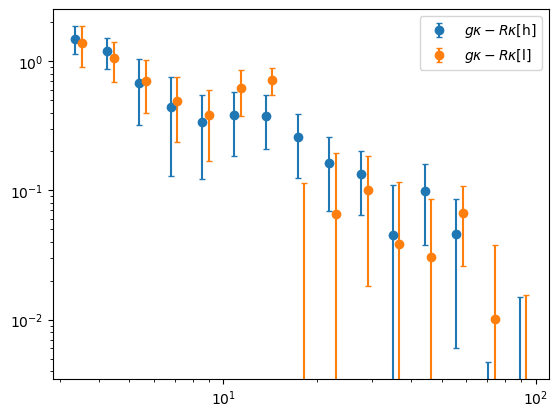

In [13]:
res_h = np.loadtxt('quasar_lss_sigma_high_L')
res_l = np.loadtxt('quasar_lss_sigma_low_L')
r_p = res_h[:,0]
plt.errorbar(r_p, res_h[:,1], res_h[:,2], capsize=2, fmt='o', label='$g\\kappa-R\\kappa$[h]')
plt.errorbar(r_p*1.05, res_l[:,1], res_l[:,2], capsize=2, fmt='o', label='$g\\kappa-R\\kappa$[l]')
plt.loglog()
plt.legend()
# plt.savefig('./fig/quasar_lss_1_sigma')

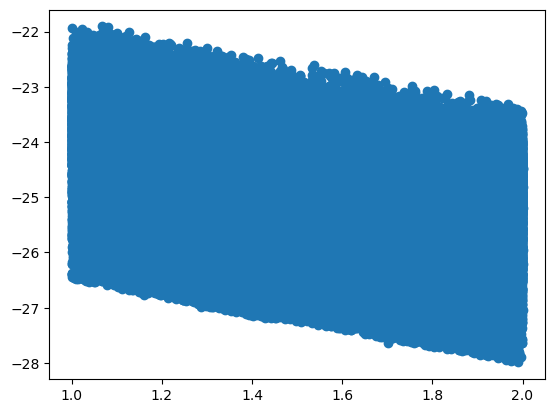

In [26]:
plt.scatter(quasar_cata['z'][valid.flatten()], M_I[valid])

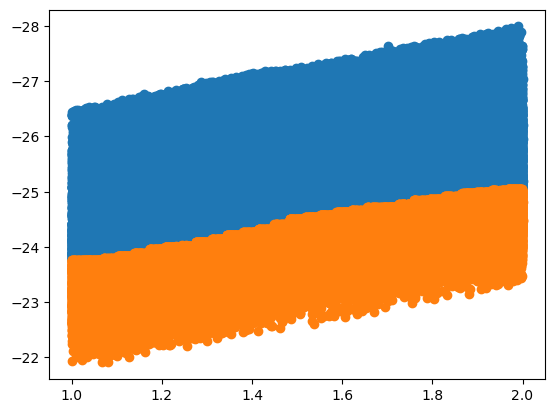

In [15]:
plt.scatter(quasar_cata['z'][index_h], M_I[index_h])
plt.scatter(quasar_cata['z'][index_l], M_I[index_l])
plt.gca().invert_yaxis()